In [1]:
!pip install Pandas pillow tensorflow pyspark pyarrow pyspark findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 18.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=008140deda6c3ead97642a8f8012c59cb12245ff5daddfc7576a1847b233b518
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from google.colab import drive
import pandas as pd
from PIL import Image
import numpy as np
import io
import os
import findspark
findspark.init()

import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras import Model
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, element_at, split
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder\
.master("local")\
.appName("demo")\
.config('spark.ui.port', '4050')\
.getOrCreate()

In [5]:

!./ngrok authtoken TOKENSNGROK
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')

!sleep 5
!curl -s http://localhost:4050/api/tunnels | grep -Po 'public_url":"(?=https)\K[^"]*'

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml
--2023-02-13 20:59:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13921656 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip.1’

ngrok-stable-linux- 100%[===================>]  13.28M  6.49MB/s    in 2.0s    

2023-02-13 20:59:11 (6.49 MB/s) - ‘ngrok-stable-linux-amd64.zip.1’ saved [13921656/13921656]

Archive:  ngrok-stable-linux-amd64.zip
replace ngrok? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [6]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
path_data = 'drive/MyDrive/Test-small/'
path_res = 'drive/MyDrive/Result_oc-csv/'

In [10]:
PATH = os.getcwd()
PATH_Data = PATH +'/'+ path_data
PATH_Result = PATH+'/'+path_res
print('PATH:        '+\
      PATH+'\n/PATH_Data:   '+\
      PATH_Data+'\nPATH_Result: '+PATH_Result)

PATH:        /content
/PATH_Data:   /content/drive/MyDrive/Test-small/
PATH_Result: /content/drive/MyDrive/Result_oc-csv/


In [11]:
sc = spark.sparkContext

In [12]:
spark

# Chargement des données

In [13]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load(PATH_Data)

In [14]:
images = images.withColumn('label', element_at(split(images['path'], '/'),-2))
print(images.printSchema())
print(images.select('path','label').show(5,False))

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- content: binary (nullable = true)
 |-- label: string (nullable = true)

None
+-------------------------------------------------------------------+------------------+
|path                                                               |label             |
+-------------------------------------------------------------------+------------------+
|file:/content/drive/MyDrive/Test-small/Avocado/4_100.jpg           |Avocado           |
|file:/content/drive/MyDrive/Test-small/Apple Granny Smith/3_100.jpg|Apple Granny Smith|
+-------------------------------------------------------------------+------------------+

None


 # chargement du model

In [ ]:
# model = MobileNetV2(weights='imagenet',
#                     include_top=True,
#                     input_shape=(224, 224, 3))
# new_model = Model(inputs=model.input,
#                   outputs=model.layers[-2].output)
# brodcast_weights = sc.broadcast(new_model.get_weights())

In [15]:

def model_fn():
    """
    Returns a MobileNetV2 model with top layer removed 
    and broadcasted pretrained weights.
    """
    model = MobileNetV2(weights='imagenet',
                        include_top=True,
                        input_shape=(224, 224, 3))
    for layer in model.layers:
        layer.trainable = False
    new_model = Model(inputs=model.input,
                  outputs=model.layers[-2].output)
    return new_model

In [16]:
from pyspark.ml.feature import StandardScaler, PCA

In [17]:
%%time

from pyspark.ml.functions import array_to_vector, vector_to_array
from pyspark.sql.functions import pandas_udf
from pyspark.sql.types import DoubleType



def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)).resize([224, 224])
    arr = img_to_array(img)
    return preprocess_input(arr)


def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess))
    preds = model.predict(input)
    # For some layers, output features will be multi-dimensional tensors.
    # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
    output = [p.flatten() for p in preds]
    return pd.Series(output)

@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).

    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
    '''
    # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
    # for multiple data batches.  This amortizes the overhead of loading big models.
    model = model_fn()
    model.set_weights(brodcast_weights.value)
    

    for content_series in content_series_iter:
        yield featurize_series(model, content_series)


# used to distributed weights
model = model_fn()
brodcast_weights = sc.broadcast(model.get_weights())

# main fonction
features_df = images.repartition(20).select(col("path"),
                                            col("label"),
                                            featurize_udf("content").alias("features")
                                           )

# transform array to vector
features_df = features_df.withColumn('features', array_to_vector('features'))

# scale data
scaler = StandardScaler(
    inputCol = 'features', 
    outputCol = 'scaledFeatures',
    withMean = True,
    withStd = True
).fit(features_df)
features_df = scaler.transform(features_df)

# make pca on data scaled
n_components = 80
pca_model = PCA(
    k = n_components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'pcaFeatures'
).fit(features_df)

print('Explained Variance Ratio', pca_model.explainedVariance.toArray())
features_df = pca_model.transform(features_df)


# drop scaled data
# transform vector to array for saving
features_df = (features_df
                  .drop("scaledFeatures")
                  .withColumn('features', vector_to_array('features'))
                  .withColumn('pcaFeatures', vector_to_array('pcaFeatures')))


# save
features_df.write.mode("overwrite").parquet(PATH_Result)
features_df.limit(5).show()

/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


14536120/14536120 [==============================] - 1s 0us/step
Explained Variance Ratio [1.00000000e+00 6.36241040e-14 6.30601294e-14 6.29134293e-14
 5.50881299e-14 5.27145599e-14 4.30119324e-14 3.90350744e-14
 3.58922922e-14 3.37373848e-14 3.03241046e-14 2.60727323e-14
 2.47791933e-14 2.38759707e-14 2.21914939e-14 2.19439346e-14
 2.18524786e-14 2.16300838e-14 2.01351869e-14 1.83365105e-14
 1.82272199e-14 1.40930382e-14 1.40530104e-14 1.01809841e-14
 1.01442286e-14 9.72554754e-15 9.05054091e-15 7.42534327e-15
 4.12428123e-15 2.26502664e-15 1.35319446e-15 1.29790191e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703e-16
 1.10964703e-16 1.10964703e-16 1.10964703e-16 1.10964703

ValueError: ignored

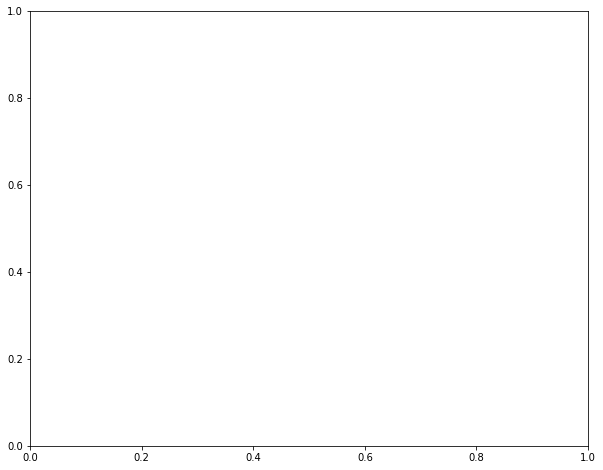

In [18]:
import matplotlib.pyplot as plt
cumValues = pca_model.explainedVariance.cumsum()
cumValues
plt.figure(figsize=(10,8))
plt.plot(range(1,201), cumValues, marker = 'o', linestyle='--')

# Chargement des données enregistrées

In [19]:
df = pd.read_parquet(PATH_Result, engine='pyarrow')

In [20]:
df.head()

,path,label,features,pcaFeatures
0,file:/content/drive/MyDrive/Test-small/Avocado...,Avocado,"[0.3310691714286804, 0.0, 0.23513704538345337,...","[21.954498400100114, 1.6486811915683575e-13, -..."
1,file:/content/drive/MyDrive/Test-small/Apple G...,Apple Granny Smith,"[0.450496643781662, 0.8337062001228333, 0.0, 0...","[-21.954498400100114, -1.6486811915683575e-13,..."


In [22]:
df.to_csv(PATH_Result+'res_csv.csv')

In [ ]:
print(df.loc[0,'features'].shape)

(1280,)


In [26]:
type(df)

pandas.core.frame.DataFrame

In [ ]:
df.head()

,path,label,features
0,file:/content/drive/MyDrive/Test1/Cherry 2/r_7...,Cherry 2,"[0.04813306, 3.5510817, 0.09194275, 0.0, 0.005..."
1,file:/content/drive/MyDrive/Test1/Clementine/r...,Clementine,"[0.008134647, 0.0, 0.0, 0.0, 0.18248017, 0.0, ..."
2,file:/content/drive/MyDrive/Test1/Redcurrant/r...,Redcurrant,"[0.18862423, 0.31768352, 0.15633708, 0.0238414..."
3,file:/content/drive/MyDrive/Test1/Peach 2/r_78...,Peach 2,"[0.061240926, 0.0, 0.0, 0.0, 0.0, 0.08017944, ..."
4,file:/content/drive/MyDrive/Test1/Redcurrant/2...,Redcurrant,"[0.87414217, 0.0, 0.0, 0.0, 0.18095696, 0.0, 0..."
